In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
import pickle
import dml_algorithm

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.svm import SVR, SVC

# Import dataset and preprocessing

http://qed.econ.queensu.ca/jae/2000-v15.6/bilias/readme.b.txt

https://colab.research.google.com/github/CausalAIBook/MetricsMLNotebooks/blob/main/CM1/python-rct-penn-precision-adj.ipynb

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/VC2015/DMLonGitHub/master/penn_jae.dat", sep='\s+')
df

,abdt,tg,inuidur1,inuidur2,female,black,hispanic,othrace,dep,q1,...,q5,q6,recall,agelt35,agegt54,durable,nondurable,lusd,husd,muld
0,10824,0,18,18,0,0,0,0,2,0,...,1,0,0,0,0,0,0,0,1,0
1,10635,2,7,3,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,10551,5,18,6,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,10824,0,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,10747,0,27,27,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13908,10831,5,27,27,0,0,0,0,0,0,...,1,0,1,0,1,1,0,0,1,0
13909,10677,2,4,4,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
13910,10817,4,4,4,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
13911,10691,0,27,27,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0


In [3]:
df['log_dur'] = np.log(df['inuidur1'])
df = df.drop(['abdt', 'inuidur1', 'inuidur2'], axis=1)
df

,tg,female,black,hispanic,othrace,dep,q1,q2,q3,q4,...,q6,recall,agelt35,agegt54,durable,nondurable,lusd,husd,muld,log_dur
0,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2.890372
1,2,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,1.945910
2,5,1,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,2.890372
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.000000
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,3.295837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13908,5,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,0,1,0,3.295837
13909,2,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,1.386294
13910,4,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1.386294
13911,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,0,1,0,0,3.295837


In [4]:
(df[['q1', 'q2', 'q3', 'q4', 'q5', 'q6']].sum(axis=1) == 1).all()

True

In [5]:
# Ordinal encoding (also to remove possible multicollinearity)
def get_quarter(row):
    for col, val in enumerate(row, start=1):
        if val == 1:
            return col

def get_age(row):
    if (row == [1, 0]).all():
        return 0
    elif (row == [0, 0]).all():
        return 1
    elif (row == [0, 1]).all():
        return 2

In [6]:
df['quarter'] = df[['q1', 'q2', 'q3', 'q4', 'q5', 'q6']].apply(get_quarter, axis=1)
df['age'] = df[['agelt35', 'agegt54']].apply(get_age, axis=1)
df['white'] = 1 - df[['black', 'hispanic', 'othrace']].sum(axis=1)
df = df.drop(['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'agelt35', 'agegt54', 'othrace'], axis=1)
df

,tg,female,black,hispanic,dep,recall,durable,nondurable,lusd,husd,muld,log_dur,quarter,age,white
0,0,0,0,0,2,0,0,0,0,1,0,2.890372,5,1,1
1,2,0,0,0,0,0,0,0,1,0,0,1.945910,3,0,1
2,5,1,0,0,0,1,0,0,0,0,0,2.890372,2,2,1
3,0,0,0,0,0,0,0,0,1,0,0,0.000000,5,1,1
4,0,0,0,0,0,0,0,0,1,0,0,3.295837,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13908,5,0,0,0,0,1,1,0,0,1,0,3.295837,5,2,1
13909,2,1,0,0,0,0,0,0,1,0,0,1.386294,4,2,1
13910,4,0,0,0,0,0,0,0,0,0,0,1.386294,5,2,1
13911,0,0,0,0,0,0,1,0,1,0,0,3.295837,4,2,1


According to https://www.jstor.org/stable/2678561?seq=11, Section 4.2, we merge treatment groups 4 and 6. 

In [7]:
df.groupby('tg').size()

tg
0    3354
1    1385
2    2428
3    1885
4    1745
5    1831
6    1285
dtype: int64

In [8]:
df = df.loc[df['tg'].isin([0, 4, 6]), :].copy()
df['treatment'] = df['tg'].isin([4, 6]).astype('float')
df = df.drop('tg', axis=1)
df

,female,black,hispanic,dep,recall,durable,nondurable,lusd,husd,muld,log_dur,quarter,age,white,treatment
0,0,0,0,2,0,0,0,0,1,0,2.890372,5,1,1,0.0
3,0,0,0,0,0,0,0,1,0,0,0.000000,5,1,1,0.0
4,0,0,0,0,0,0,0,1,0,0,3.295837,4,1,1,0.0
5,0,0,0,0,0,0,0,0,0,1,1.945910,2,1,1,1.0
11,0,0,0,0,0,0,0,0,0,1,2.197225,3,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13904,0,0,1,0,0,0,0,0,0,1,2.302585,3,0,0,1.0
13905,0,0,1,2,0,0,0,0,0,1,1.386294,2,1,0,1.0
13906,0,0,0,2,0,0,0,1,0,0,2.197225,2,0,1,0.0
13910,0,0,0,0,0,0,0,0,0,0,1.386294,5,2,1,1.0


In [9]:
df['treatment'].value_counts()

treatment
0.0    3354
1.0    3030
Name: count, dtype: int64

In [2]:
def preprocess():
    def get_quarter(row):
        for col, val in enumerate(row, start=1):
            if val == 1:
                return col
    
    def get_age(row):
        if (row == [1, 0]).all():
            return 0
        elif (row == [0, 0]).all():
            return 1
        elif (row == [0, 1]).all():
            return 2
            
    df = pd.read_csv("https://raw.githubusercontent.com/VC2015/DMLonGitHub/master/penn_jae.dat", sep='\s+')
    df['log_dur'] = np.log(df['inuidur1'])
    df = df.drop(['abdt', 'inuidur1', 'inuidur2'], axis=1)
    df['quarter'] = df[['q1', 'q2', 'q3', 'q4', 'q5', 'q6']].apply(get_quarter, axis=1)
    df['age'] = df[['agelt35', 'agegt54']].apply(get_age, axis=1)
    df['white'] = 1 - df[['black', 'hispanic', 'othrace']].sum(axis=1)
    df = df.drop(['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'agelt35', 'agegt54', 'othrace'], axis=1)
    df = df.loc[df['tg'].isin([0, 4, 6]), :].copy()
    df['treatment'] = df['tg'].isin([4, 6]).astype('float')
    df = df.drop('tg', axis=1)

    return df

In [3]:
df = preprocess()
df

,female,black,hispanic,dep,recall,durable,nondurable,lusd,husd,muld,log_dur,quarter,age,white,treatment
0,0,0,0,2,0,0,0,0,1,0,2.890372,5,1,1,0.0
3,0,0,0,0,0,0,0,1,0,0,0.000000,5,1,1,0.0
4,0,0,0,0,0,0,0,1,0,0,3.295837,4,1,1,0.0
5,0,0,0,0,0,0,0,0,0,1,1.945910,2,1,1,1.0
11,0,0,0,0,0,0,0,0,0,1,2.197225,3,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13904,0,0,1,0,0,0,0,0,0,1,2.302585,3,0,0,1.0
13905,0,0,1,2,0,0,0,0,0,1,1.386294,2,1,0,1.0
13906,0,0,0,2,0,0,0,1,0,0,2.197225,2,0,1,0.0
13910,0,0,0,0,0,0,0,0,0,0,1.386294,5,2,1,1.0


In [4]:
# Difference-in-means estimator (consistent)
ate = np.mean(df['log_dur'][df['treatment']==1]) - np.mean(df['log_dur'][df['treatment']==0])
ate

-0.0795421074545184

# Inducing selection bias

We want a positive selection bias.

In [13]:
df = preprocess()

In [14]:
df.groupby('treatment').mean()

,female,black,hispanic,dep,recall,durable,nondurable,lusd,husd,muld,log_dur,quarter,age,white
treatment,,,,,,,,,,,,,,
0.0,0.405188,0.121348,0.035480,0.438283,0.108229,0.150865,0.106738,0.253131,0.221825,0.449911,2.056830,3.712880,0.573942,0.837507
1.0,0.397360,0.114851,0.032013,0.462046,0.128713,0.140924,0.112211,0.269307,0.221782,0.430693,1.977288,3.376568,0.552805,0.844884


In [15]:
df.groupby(['female', 'treatment'])['log_dur'].mean().unstack('treatment')

treatment,0.0,1.0
female,,
0,2.022391,1.938311
1,2.107386,2.036400


$\Longrightarrow$ Discard treated males

In [16]:
df.groupby(['white', 'treatment'])['log_dur'].mean().unstack('treatment')

treatment,0.0,1.0
white,,
0,1.773045,1.746985
1,2.111889,2.019570


$\Longrightarrow$ Discard untreated white people

In [17]:
df.groupby(['dep', 'treatment'])['log_dur'].mean().unstack('treatment')

treatment,0.0,1.0
dep,,
0,2.025885,1.957493
1,2.151670,1.980621
2,2.128894,2.056520


$\Longrightarrow$ Discard treated people with 0 dependents

In [18]:
df.groupby(['recall', 'treatment'])['log_dur'].mean().unstack('treatment')

treatment,0.0,1.0
recall,,
0,2.013679,1.920627
1,2.412376,2.360835


$\Longrightarrow$ Discard treated people not expecting to be recalled

In [19]:
df.groupby(['age', 'treatment'])['log_dur'].mean().unstack('treatment')

treatment,0.0,1.0
age,,
0,1.953533,1.847155
1,2.138122,2.072886
2,2.298458,2.350884


$\Longrightarrow$ Discard treated young people

In [20]:
df.groupby(['lusd', 'treatment'])['log_dur'].mean().unstack('treatment')

treatment,0.0,1.0
lusd,,
0,2.074737,2.030473
1,2.003994,1.832982


$\Longrightarrow$ Discard treated people from areas of low unemployment rate and short duration of unemployment

In [21]:
discard_0 = (1-df.treatment) * (df.white==1)
discard_1 = df.treatment * ((df.female==0).astype(float) + (df.dep==0) + (df.recall==0) + (df.age==0) + (df.lusd==1))
discard_prob = 0.5*discard_0 + 0.1*discard_1

If we discard samples that satisfy a higher number of constraints with a higher probability, then we expect to induce a positive selection bias on the estimated causal effect.

In [22]:
np.random.seed(123)
discarded = (np.random.uniform(size=len(df)) <= discard_prob)
df_bias = df[~discarded]
df_bias

,female,black,hispanic,dep,recall,durable,nondurable,lusd,husd,muld,log_dur,quarter,age,white,treatment
0,0,0,0,2,0,0,0,0,1,0,2.890372,5,1,1,0.0
5,0,0,0,0,0,0,0,0,0,1,1.945910,2,1,1,1.0
11,0,0,0,0,0,0,0,0,0,1,2.197225,3,0,1,1.0
13,1,0,0,0,0,0,0,1,0,0,3.295837,5,2,1,0.0
14,1,0,0,1,0,0,0,1,0,0,2.197225,5,2,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13895,1,0,0,0,0,0,0,1,0,0,0.000000,6,0,0,0.0
13898,0,1,0,0,0,0,0,0,0,1,3.135494,5,1,0,0.0
13899,1,1,0,0,1,0,0,1,0,0,2.564949,4,0,0,1.0
13900,1,0,0,2,0,0,1,0,0,1,1.791759,5,1,0,0.0


In [23]:
df_bias.treatment.value_counts().sort_index()

treatment
0.0    1919
1.0    2150
Name: count, dtype: int64

In [5]:
def induce_selection_bias():
    df = preprocess()  
    
    discard_0 = (1-df.treatment) * (df.white==1)
    discard_1 = df.treatment * ((df.female==0).astype(float) + (df.dep==0) + (df.recall==0) + (df.age==0) + (df.lusd==1))
    discard_prob = 0.5*discard_0 + 0.1*discard_1
    
    np.random.seed(123)
    discarded = (np.random.uniform(size=len(df)) <= discard_prob)
    df_bias = df[~discarded]
    df_bias = df_bias.sample(frac=1)
    
    return df_bias['log_dur'].values, df_bias['treatment'].values, df_bias.drop(['treatment', 'log_dur'], axis=1).values

In [6]:
y_data, d_data, x_data = induce_selection_bias()

In [7]:
# Difference-in-means estimator (inconsistent)
dm = np.mean(y_data[d_data==1]) - np.mean(y_data[d_data==0])
dm

-0.016126545619768784

# DML estimation

In [8]:
y_data, d_data, x_data = induce_selection_bias()

scaler = StandardScaler()
x_data_stand = scaler.fit_transform(x_data)

poly_features = PolynomialFeatures(degree=2, include_bias=False)
x_data_quad = poly_features.fit_transform(x_data)
scaler = StandardScaler()
x_data_quad_stand = scaler.fit_transform(x_data_quad)

In [9]:
with open('opt_params.pkl', 'rb') as pickle_file:
    opt_params = pickle.load(pickle_file)

opt_params

{'eln': {'g0': {'alpha': 0.09752529989145678, 'l1_ratio': 0.1},
  'g1': {'alpha': 0.12719497957648263, 'l1_ratio': 0.1},
  'm': {'C': 0.019306977288832496, 'l1_ratio': 0.95}},
 'mlp': {'g0': {'alpha': 0.03,
   'batch_size': 2,
   'hidden_layer_sizes': (24, 16),
   'max_iter': 50},
  'g1': {'alpha': 1,
   'batch_size': 32,
   'hidden_layer_sizes': (16, 8, 4),
   'max_iter': 125},
  'm': {'alpha': 0.03,
   'batch_size': 4,
   'hidden_layer_sizes': (16, 8),
   'max_iter': 25}},
 'rf': {'g0': {'max_depth': 5,
   'max_features': 'sqrt',
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 200},
  'g1': {'max_depth': 5,
   'max_features': None,
   'min_samples_leaf': 1,
   'min_samples_split': 10,
   'n_estimators': 1000},
  'm': {'max_depth': 5,
   'max_features': 'sqrt',
   'min_samples_leaf': 4,
   'min_samples_split': 10,
   'n_estimators': 750}},
 'svm': {'g0': {'C': 0.3, 'epsilon': 1, 'gamma': 0.03, 'kernel': 'rbf'},
  'g1': {'C': 3, 'epsilon': 1, 'gamma': 0.01, 'ker

In [10]:
results = {}

## Elastic net

In [11]:
def get_eln_models(eln_params_dict):
    model_g = []
    for d in [0, 1]:
        model = ElasticNet(max_iter=10000)
        model.set_params(**eln_params_dict[f'g{d}'])
        model_g.append(model)
    model_m = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=50000, random_state=42)
    model_m.set_params(**eln_params_dict['m'])
    return model_g, model_m

In [12]:
eln_model_g, eln_model_m = get_eln_models(opt_params['eln'])
results['Elastic net'] = dml_algorithm.dml_ate_att(y_data, d_data, x_data_quad_stand, eln_model_g, eln_model_m, m_bounds=(0.01, 0.99))
results['Elastic net']

([-0.09094766265523736, 2.3974808841114803, array([-0.16461236, -0.01728297])],
 [-0.09071372925783808, 2.386152785842013, array([-0.16403036, -0.0173971 ])])

## Support vector machine

In [13]:
def get_svm_models(svm_params_dict):
    model_g = []
    for d in [0, 1]:
        model = SVR()
        model.set_params(**svm_params_dict[f'g{d}'])
        model_g.append(model)
    model_m = SVC(probability=True, random_state=42)
    model_m.set_params(**svm_params_dict['m'])
    return model_g, model_m

In [14]:
svm_model_g, svm_model_m = get_svm_models(opt_params['svm'])
results['SVM'] = dml_algorithm.dml_ate_att(y_data, d_data, x_data_stand, svm_model_g, svm_model_m, m_bounds=(0.01, 0.99))
results['SVM']

([-0.07963577040521302, 2.4365377315452803, array([-0.15450052, -0.00477102])],
 [-0.08045122540576523, 2.4365011895919606, array([-0.15531485, -0.0055876 ])])

## Random forest

In [15]:
def get_rf_models(rf_params_dict):
    model_g = []
    for d in [0, 1]:
        model = RandomForestRegressor(random_state=42)
        model.set_params(**rf_params_dict[f'g{d}'])
        model_g.append(model)
    model_m = RandomForestClassifier(criterion='log_loss', random_state=42)
    model_m.set_params(**rf_params_dict['m'])
    return model_g, model_m

In [16]:
rf_model_g, rf_model_m = get_rf_models(opt_params['rf'])
results['Random forest'] = dml_algorithm.dml_ate_att(y_data, d_data, x_data, rf_model_g, rf_model_m, m_bounds=(0.01, 0.99))
results['Random forest']

([-0.08061395656334512, 2.4126473694201622, array([-0.15474466, -0.00648326])],
 [-0.08426692809796789, 2.399494401014703, array([-0.15799349, -0.01054037])])

## XGBoost

In [17]:
def get_xgb_models(xgb_params_dict):
    model_g = []
    for d in [0, 1]:
        model = xgb.XGBRegressor(objective='reg:squarederror', seed=0)
        model.set_params(**xgb_params_dict[f'g{d}'])
        model_g.append(model)
    model_m = xgb.XGBClassifier(objective='binary:logistic', seed=0)
    model_m.set_params(**xgb_params_dict['m'])
    return model_g, model_m

In [18]:
xgb_model_g, xgb_model_m = get_xgb_models(opt_params['xgb'])
results['XGBoost'] = dml_algorithm.dml_ate_att(y_data, d_data, x_data, xgb_model_g, xgb_model_m, m_bounds=(0.01, 0.99))
results['XGBoost']

([-0.08572800296044722, 2.455309476772988, array([-0.16116953, -0.01028647])],
 [-0.08956815235099504, 2.443845284258686, array([-0.16465743, -0.01447887])])

## Multilayer perceptron

In [19]:
def get_mlp_models(mlp_params_dict):
    model_g = []
    for d in [0, 1]:
        model = MLPRegressor(random_state=42)
        model.set_params(**mlp_params_dict[f'g{d}'])
        model_g.append(model)
    model_m = MLPClassifier(random_state=42)
    model_m.set_params(**mlp_params_dict['m'])
    return model_g, model_m

In [20]:
mlp_model_g, mlp_model_m = get_mlp_models(opt_params['mlp'])
results['MLP'] = dml_algorithm.dml_ate_att(y_data, d_data, x_data_stand, mlp_model_g, mlp_model_m, m_bounds=(0.01, 0.99))
results['MLP']

([-0.08651509365076579, 2.4308331179975, array([-0.16120457, -0.01182562])],
 [-0.08925126237119003, 2.40288296119126, array([-0.16308194, -0.01542058])])

# Visualization

In [21]:
colors = ['tab:red', 'tab:green', 'tab:pink', 'tab:orange', 'tab:purple']

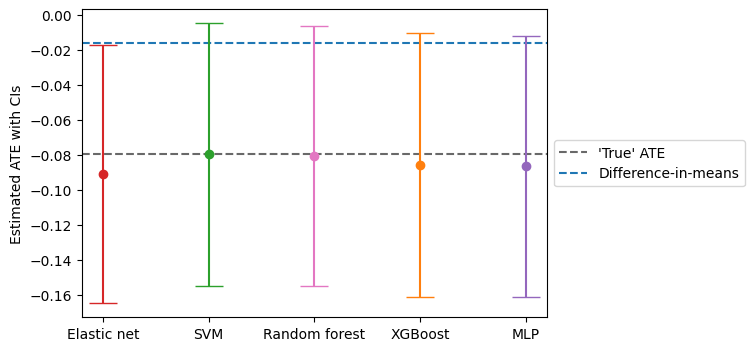

In [22]:
plt.figure(figsize=(6, 4))

plt.axhline(y=ate, color='dimgrey', linestyle='--', label="'True' ATE")
plt.axhline(y=dm, color='tab:blue', linestyle='--', label='Difference-in-means')

for i, (ml_name, result) in enumerate(results.items()):
    plt.errorbar(ml_name, result[0][0], yerr=result[0][2][1]-result[0][0], fmt='o', capsize=10, color=colors[i])

plt.ylabel('Estimated ATE with CIs')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for fmt in ['png', 'pdf']:
    plt.savefig(f'reemployment_ate.{fmt}', dpi=300, bbox_inches='tight')

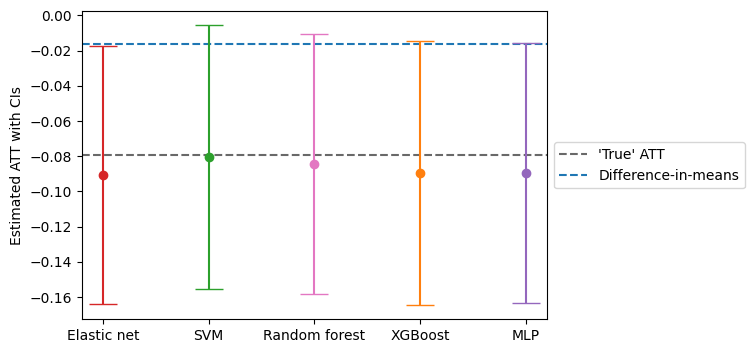

In [23]:
plt.figure(figsize=(6, 4))

plt.axhline(y=ate, color='dimgrey', linestyle='--', label="'True' ATT")
plt.axhline(y=dm, color='tab:blue', linestyle='--', label='Difference-in-means')

for i, (ml_name, result) in enumerate(results.items()):
    plt.errorbar(ml_name, result[1][0], yerr=result[1][2][1]-result[1][0], fmt='o', capsize=10, color=colors[i])

plt.ylabel('Estimated ATT with CIs')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for fmt in ['png', 'pdf']:
    plt.savefig(f'reemployment_att.{fmt}', dpi=300, bbox_inches='tight')